In [1]:
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Lasso, Ridge, LinearRegression
# from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_squared_log_error
from statsmodels.formula.api import ols
import statsmodels.api as sm
import scipy.stats as stats

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

pd.set_option('display.max_columns',100)

In [448]:
model_cols = ['player','pos','season','year','age','experience','g','mp','2p_pct','3p_pct','ft_pct','pts','trb','ast','stl','blk','tov','pf','ws']
final_df = pd.read_pickle('final_df.pickle')
final_df = final_df[final_df.tm != 'TOT']
final_df = final_df[model_cols]
# final_df = pd.get_dummies(data=final_df, columns=['tm'])
final_df = pd.get_dummies(data=final_df, columns=['pos'])

final_df.rename(columns={'year':'draft_year',
                         '2p_pct':'fg2_pct',
                         '3p_pct':'fg3_pct'}, inplace=True)

final_df = final_df.merge(final_df.groupby('player').max()[['season']].reset_index(),on='player',how='left',suffixes=('','_max'))

In [449]:
final_df = final_df.drop('pos_C', axis=1)

In [450]:
features = final_df[['season', 'draft_year', 'age', 'experience', 'g', 'mp',
       'fg2_pct', 'fg3_pct', 'ft_pct', 'pts', 'trb', 'ast', 'stl', 'blk',
       'tov', 'pf', 'ws', 'pos_PF', 'pos_PG', 'pos_SF', 'pos_SG',
       'season_max']]

tranformed_feats = scale.fit_transform(features)
features = pd.DataFrame(tranformed_feats, columns=features.columns)

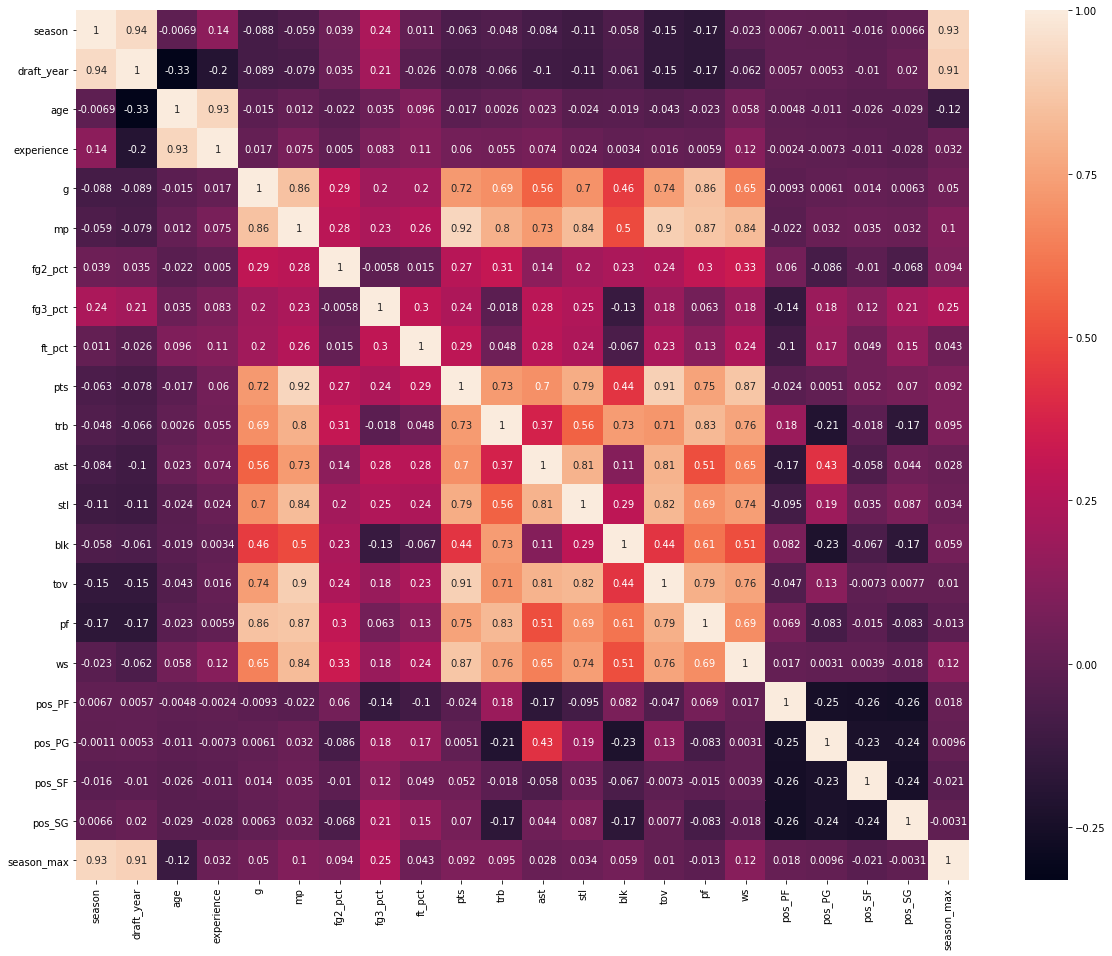

In [834]:
plt.figure(figsize=(20,16))
sns.heatmap(features.corr(), annot=True)

In [847]:
final_df[final_df.season == final_df.season_max]

,player,season,draft_year,age,experience,g,mp,fg2_pct,fg3_pct,ft_pct,pts,trb,ast,stl,blk,tov,pf,ws,pos_PF,pos_PG,pos_SF,pos_SG,season_max
5,Gus Bailey,1980,1974,28,5,20,180,0.441,1.000,0.385,38,28,26,7,4,11,18,0.2,0,0,0,1,1980
9,Marvin Barnes,1980,1974,27,3,20,287,0.400,0.000,0.500,64,77,18,5,12,18,52,0.1,1,0,0,0,1980
10,Rick Barry,1980,1965,35,14,72,1816,0.458,0.330,0.935,866,236,268,80,28,152,182,3.4,0,0,1,0,1980
11,Tim Bassett,1980,1973,28,3,7,92,0.364,0.000,0.667,24,18,4,5,0,4,14,0.1,1,0,0,0,1980
12,Tim Bassett,1980,1973,28,3,5,72,0.333,0.000,0.667,10,15,10,3,0,5,13,0.0,1,0,0,0,1980
14,Ron Behagen,1980,1973,29,6,6,64,0.391,0.000,0.833,23,14,7,0,4,4,14,0.1,1,0,0,0,1980
22,Lawrence Boston,1980,1978,23,0,13,125,0.462,0.000,0.615,56,39,2,4,2,8,25,0.2,1,0,0,0,1980
26,Alonzo Bradley,1980,1977,26,2,22,96,0.340,1.000,0.667,41,6,3,3,0,8,9,-0.2,0,0,1,0,1980
34,John Brown,1980,1973,28,6,4,24,0.000,0.000,1.000,4,9,4,0,0,5,4,-0.1,0,0,1,0,1980
35,John Brown,1980,1973,28,6,28,361,0.378,0.000,0.773,108,62,14,3,4,24,66,0.2,0,0,1,0,1980


# Linear Models

### Base prediction: Win share actual - mean win share

In [457]:
# Mean squared error of using just the mean of ws to predict ws
np.mean((final_df.ws-final_df.ws.mean())**2)

9.50320572275705

### Ordinary Least Squares (OLS)

In [488]:
def refine_model(model, old_ivs, pval, df=final_df[final_df.season != final_df.season_max]):
    """
    Checks p-value for each independent variable and removes the variables having p-value above (pval) threshold
    """
    pdf = pd.DataFrame(model.pvalues, columns=['pvalue'])        # Creating a p-value DF

    removers = list(pdf[pdf['pvalue']>pval].transpose().columns) # List of variables to remove
    new_ivs = [iv for iv in old_ivs if iv not in removers]       # Updated list of independent variables
    IVs = ''.join(name+'+' for name in new_ivs).strip('+')       # Creates string for input in OLS model

    # Prints the count of variables
    print(len(new_ivs))

    # Creates the new model
    new_model = ols(formula=f'ws~{IVs}', data=df).fit()

    # Returning the new model, list of remaining IVs, new max p-value
    return new_model, new_ivs, round(new_model.pvalues.max(),2)

In [489]:
ivs = [col for col in X_train.columns if col != 'pos_C']
iv_string = ''.join(col+'+' for col in ivs).strip('+')

In [490]:
iv_string

'season+draft_year+age+experience+g+mp+fg2_pct+fg3_pct+ft_pct+pts+trb+ast+stl+blk+tov+pf+pos_PF+pos_PG+pos_SF+pos_SG'

In [491]:
lr_model = ols(formula=f'ws~{iv_string}',data=final_df).fit()

lr_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                     ws   R-squared:                       0.876
Model:                            OLS   Adj. R-squared:                  0.875
Method:                 Least Squares   F-statistic:                     5433.
Date:                Mon, 21 Oct 2019   Prob (F-statistic):               0.00
Time:                        12:16:26   Log-Likelihood:                -23304.
No. Observations:               15471   AIC:                         4.665e+04
Df Residuals:                   15450   BIC:                         4.681e+04
Df Model:                          20                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      2.9094      1.942      1.498      0.134      -0.898       6.716
season         0.0135      0.013      1.044      0.297      -0.012       0.039
draft_year    -0.0166      0.013     -1.275      0.202      -0.042       0.009
age            0.0576      0.008      7.534      0.000       0.043       0.073
experience    -0.0510      0.011     -4.719      0.000      -0.072      -0.030
g             -0.0034      0.001     -4.233      0.000      -0.005      -0.002
mp            -0.0008   4.77e-05    -17.669      0.000      -0.001      -0.001
fg2_pct        3.3025      0.118     28.076      0.000       3.072       3.533
fg3_pct        0.0762      0.059      1.302      0.193      -0.039       0.191
ft_pct         0.5881      0.071      8.282      0.000       0.449       0.727
pts            0.0059   6.04e-05     97.445      0.000       0.006       0.006
trb            0.0071      0.000     63.398      0.000       0.007       0.007
ast            0.0103      0.000     62.404      0.000       0.010       0.011
stl            0.0119      0.000     23.897      0.000       0.011       0.013
blk            0.0082      0.000     23.096      0.000       0.007       0.009
tov           -0.0338      0.000    -73.755      0.000      -0.035      -0.033
pf            -0.0010      0.000     -2.993      0.003      -0.002      -0.000
pos_PF        -0.0904      0.029     -3.149      0.002      -0.147      -0.034
pos_PG        -0.0842      0.041     -2.071      0.038      -0.164      -0.005
pos_SF        -0.0943      0.034     -2.791      0.005      -0.161      -0.028
pos_SG        -0.0892      0.037     -2.402      0.016      -0.162      -0.016
==============================================================================
Omnibus:                     1245.672   Durbin-Watson:                   1.870
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             7053.889
Skew:                           0.140   Prob(JB):                         0.00
Kurtosis:                       6.296   Cond. No.                     7.10e+05
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 7.1e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

#### Refining OLS Model

In [501]:
ref1 = refine_model(lr_model,ivs,.9)
ref2 = refine_model(ref1[0],ref1[1],ref1[2])
ref3 = refine_model(ref2[0],ref2[1],ref2[2])
ref4 = refine_model(ref3[0],ref3[1],ref3[2])
ref5 = refine_model(ref4[0],ref4[1],ref4[2])
ref6 = refine_model(ref5[0],ref5[1],ref5[2])

20
19
18
17
16
15


In [498]:
ref2[2]

0.39

In [505]:
ref6[0].summary()
ref6[1]

['season',
 'draft_year',
 'age',
 'experience',
 'mp',
 'fg2_pct',
 'ft_pct',
 'pts',
 'trb',
 'ast',
 'stl',
 'blk',
 'tov',
 'pf',
 'pos_PF']

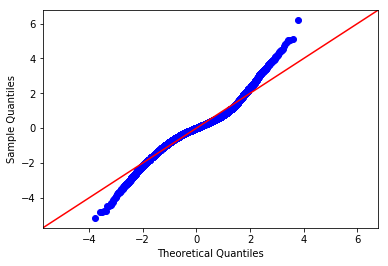

In [468]:
sm.graphics.qqplot(ref2[0].resid, dist=stats.norm, line='45', fit=True)
plt.show()

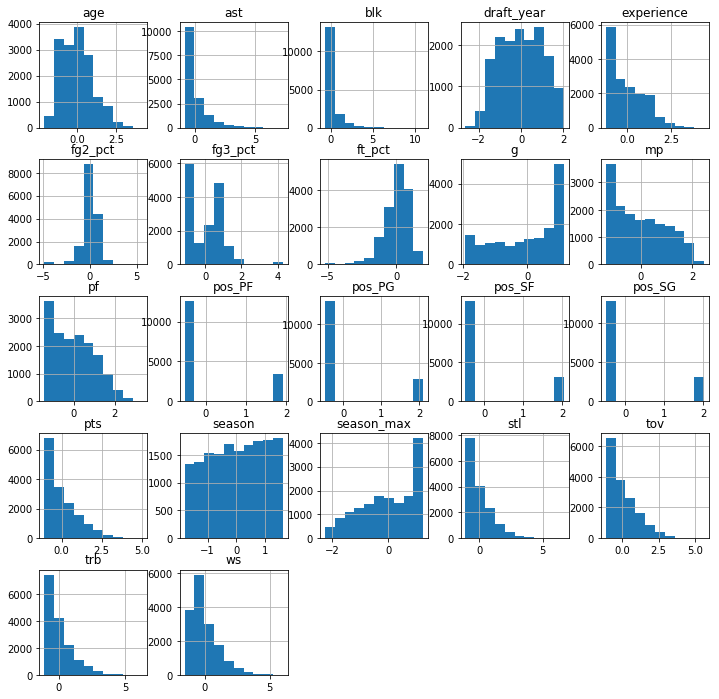

In [509]:
features.hist(figsize=(12,12))
plt.show()

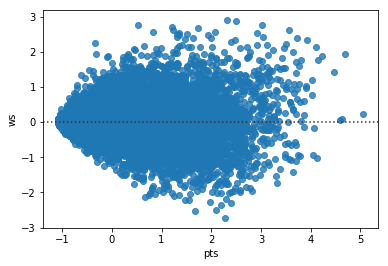

In [840]:
sns.residplot(features.pts, features.ws)

In [433]:
final_df.groupby('player').count().experience

player
A.C. Green              17
A.J. Bramlett            1
A.J. English             2
A.J. Guyton              3
A.J. Hammons             1
A.J. Price               8
Aaron Brooks            13
Aaron Gordon             5
Aaron Gray               9
Aaron Holiday            1
Aaron McKie             15
Abdel Nader              2
Acie Earl                5
Acie Law                 7
Adam Keefe               9
Adam Morrison            4
Adonal Foyle            13
Adonis Jordan            2
Adreian Payne            5
Adrian Branch            4
Adrian Dantley          13
Al Harrington           18
Al Horford              12
Al Jefferson            14
Al Skinner               1
Al Thornton              6
Al Wood                  7
Al-Farouq Aminu          9
Alaa Abdelnaby           7
Alan Henderson          12
                        ..
Willie White             2
Willy Hernangómez        4
Wilson Chandler         13
Winford Boynes           2
Winston Bennett          4
Winston Crite        

In [434]:
final_df[final_df.season != final_df.season_max].groupby('player').sum().drop(['season','draft_year','season_max'],axis=1)

,age,experience,g,mp,fg2_pct,fg3_pct,ft_pct,pts,trb,ast,stl,blk,tov,pf,ws,pos_PF,pos_PG,pos_SF,pos_SG
player,,,,,,,,,,,,,,,,,,,
A.C. Green,468,116,1196,35141,8.079,2.593,11.383,11964,9160,1361,1003,538,1389,2317,96.2,14,0,2,0
A.J. English,23,0,70,1443,0.458,0.097,0.707,616,147,177,25,15,114,127,0.2,0,0,0,1
A.J. Guyton,45,1,78,1237,0.762,0.765,1.648,442,80,145,19,12,61,58,0.4,0,2,0,0
A.J. Price,125,10,235,3605,2.252,1.538,3.057,1390,345,521,118,9,215,222,4.4,0,4,0,1
Aaron Brooks,331,55,613,13250,5.207,4.260,9.203,6184,1062,1905,353,87,989,1189,19.1,0,12,0,0
Aaron Gordon,82,6,263,6867,2.056,1.191,2.806,3003,1538,447,204,162,300,519,13.0,3,0,1,0
Aaron Gray,178,17,281,3496,3.548,0.000,3.840,1001,1079,185,84,79,234,614,6.0,0,0,0,0
Aaron McKie,379,71,783,19025,6.148,4.240,10.492,5849,2569,2113,908,164,1051,1574,39.9,0,1,3,10
Abdel Nader,24,0,48,522,0.321,0.354,0.590,146,71,26,15,10,34,45,-0.1,0,0,1,0


### Lasso and Ridge Models

In [890]:
final_df.fillna(0,inplace=True)

In [891]:
X_train = final_df[final_df.season != final_df.season_max].drop(['player','ws','season_max'],axis=1)
y_train = final_df[final_df.season != final_df.season_max]['ws']

X_test = final_df[final_df.season == final_df.season_max].drop(['player','ws','season_max'],axis=1)
y_test = final_df[final_df.season == final_df.season_max]['ws']

scale = StandardScaler()
transformed1 = scale.fit_transform(X_train)
X_train = pd.DataFrame(transformed1, columns = X_train.columns)

transformed2 = scale.fit_transform(X_test)
X_test = pd.DataFrame(transformed2, columns = X_test.columns)

In [892]:
# Build a Ridge, Lasso and regular linear regression model. 
# Note that in scikit learn, the regularization parameter is denoted by alpha (and not lambda)
ridge1 = Ridge(alpha=0.5)
ridge1.fit(X_train, y_train)

lasso1 = Lasso(alpha=0.5)
lasso1.fit(X_train, y_train)

lin = LinearRegression()
lin.fit(X_train, y_train)

pass

In [893]:
# Create preditions for training and test sets 
y_h_ridge_train1 = ridge1.predict(X_train)
y_h_ridge_test1 = ridge1.predict(X_test)

y_h_lasso_train1 = lasso1.predict(X_train)
y_h_lasso_test1 = lasso1.predict(X_test)

y_h_lin_train = lin.predict(X_train)
y_h_lin_test = lin.predict(X_test)

In [894]:
# Print errors 
print('Train Error Ridge Model', np.sum((y_train - y_h_ridge_train1)**2))
print('Test Error Ridge Model', np.sum((y_test - y_h_ridge_test1)**2))
print('\n')

print('Train Error Lasso Model', np.sum((y_train - y_h_lasso_train1)**2))
print('Test Error Lasso Model', np.sum((y_test - y_h_lasso_test1)**2))
print('\n')

print('Train Error Unpenalized Linear Model', np.sum((y_train - lin.predict(X_train))**2))
print('Test Error Unpenalized Linear Model', np.sum((y_test - lin.predict(X_test))**2))

Train Error Ridge Model 17289.911201824023
Test Error Ridge Model 25171.853785964944


Train Error Lasso Model 33356.31698846702
Test Error Lasso Model 18779.64461070916


Train Error Unpenalized Linear Model 17289.898915408186
Test Error Unpenalized Linear Model 25177.26063974265


In [895]:
# Linear regression 
print('Training r^2:', lin.score(X_train, y_train))
print('Testing r^2:', lin.score(X_test, y_test))
print('Training MSE:', mean_squared_error(y_train, lin.predict(X_train)))
print('Testing MSE:', mean_squared_error(y_test, lin.predict(X_test)))

Training r^2: 0.8693372571357607
Testing r^2: -2.443123390538653
Training MSE: 1.3051935468716076
Testing MSE: 9.125502225350726


In [896]:
# Ridge regression 
print('Training r^2:', ridge1.score(X_train, y_train))
print('Testing r^2:', ridge1.score(X_test, y_test))
print('Training MSE:', mean_squared_error(y_train, ridge1.predict(X_train)))
print('Testing MSE:', mean_squared_error(y_test, ridge1.predict(X_test)))

Training r^2: 0.869337164285201
Testing r^2: -2.442383974723024
Training MSE: 1.3051944743582715
Testing MSE: 9.123542510317124


In [897]:
# Lasso regression 
print('Training r^2:', lasso1.score(X_train, y_train))
print('Testing r^2:', lasso1.score(X_test, y_test))
print('Training MSE:', mean_squared_error(y_train, lasso1.predict(X_train)))
print('Testing MSE:', mean_squared_error(y_test, lasso1.predict(X_test)))

Training r^2: 0.7479205696409228
Testing r^2: -1.5682156033714079
Training MSE: 2.518028005470448
Testing MSE: 6.806685252159899


In [898]:
# Print coefficients 
print('Ridge parameter coefficients: \n', ridge1.coef_)
print('Lasso parameter coefficients: \n', lasso1.coef_)
print('Linear model parameter coefficients: \n', lin.coef_)

Ridge parameter coefficients: 
 [ 0.4123253  -0.41088118  0.23349006 -0.25232014 -0.06488141 -0.85296158
  0.27662513  0.02092826  0.03151876  3.02642239  1.50739918  1.54409845
  0.45283462  0.32920923 -2.33148639 -0.05360682 -0.03165417 -0.00886203
 -0.02103129 -0.01810068]
Lasso parameter coefficients: 
 [ 0.         -0.          0.          0.          0.          0.
  0.          0.          0.          1.66639594  0.56955248  0.06049216
  0.13840246  0.          0.          0.          0.          0.
 -0.         -0.        ]
Linear model parameter coefficients: 
 [ 0.42132787 -0.42009272  0.23275407 -0.25470453 -0.06456823 -0.85539043
  0.27653353  0.02087161  0.03144865  3.02854842  1.50821117  1.54538912
  0.45277817  0.32920962 -2.33365311 -0.05283864 -0.03161055 -0.00863423
 -0.0208261  -0.01782701]


#### Refining Lasso and Ridge Models

In [899]:
# Build a Ridge, Lasso and regular linear regression model. 
# Note that in scikit learn, the regularization parameter is denoted by alpha (and not lambda)
ridge2 = Ridge(alpha=0.3)
ridge2.fit(X_train, y_train)

lasso2 = Lasso(alpha=0.3)
lasso2.fit(X_train, y_train)

lin = LinearRegression()
lin.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)

In [900]:
# Create preditions for training and test sets 
y_h_ridge_train2 = ridge2.predict(X_train)
y_h_ridge_test2 = ridge2.predict(X_test)

y_h_lasso_train2 = lasso2.predict(X_train)
y_h_lasso_test2 = lasso2.predict(X_test)

y_h_lin_train = lin.predict(X_train)
y_h_lin_test = lin.predict(X_test)

In [901]:
# Print errors 
print('Train Error Ridge Model', np.sum((y_train - y_h_ridge_train2)**2))
print('Test Error Ridge Model', np.sum((y_test - y_h_ridge_test2)**2))
print('\n')

print('Train Error Lasso Model', np.sum((y_train - y_h_lasso_train2)**2))
print('Test Error Lasso Model', np.sum((y_test - y_h_lasso_test2)**2))
print('\n')

print('Train Error Unpenalized Linear Model', np.sum((y_train - lin.predict(X_train))**2))
print('Test Error Unpenalized Linear Model', np.sum((y_test - lin.predict(X_test))**2))

Train Error Ridge Model 17289.903365716003
Test Error Ridge Model 25174.011619917204


Train Error Lasso Model 29544.788286998362
Test Error Lasso Model 20154.20207778652


Train Error Unpenalized Linear Model 17289.898915408186
Test Error Unpenalized Linear Model 25177.26063974265


In [917]:
# Ridge regression 2 
print('Training r^2:', ridge2.score(X_train, y_train))
print('Testing r^2:', ridge2.score(X_test, y_test))
print('Training MSE:', mean_squared_error(y_train, ridge2.predict(X_train)))
print('Testing MSE:', mean_squared_error(y_test, ridge2.predict(X_test)))

Training r^2: 0.8693372235040184
Testing r^2: -2.4426790699146825
Training MSE: 1.3051938828199594
Testing MSE: 9.124324617585069


In [918]:
# Lasso regression 2 
print('Training r^2:', lasso2.score(X_train, y_train))
print('Testing r^2:', lasso2.score(X_test, y_test))
print('Training MSE:', mean_squared_error(y_train, lasso2.predict(X_train)))
print('Testing MSE:', mean_squared_error(y_test, lasso2.predict(X_test)))

Training r^2: 0.7767249482596922
Testing r^2: -1.7561935980489887
Training MSE: 2.23030031607144
Testing MSE: 7.304893830295947


In [916]:
# Linear regression 
print('Training r^2:', lin.score(X_train, y_train))
print('Testing r^2:', lin.score(X_test, y_test))
print('Training MSE:', mean_squared_error(y_train, lin.predict(X_train)))
print('Testing MSE:', mean_squared_error(y_test, lin.predict(X_test)))

Training r^2: 0.8693372571357607
Testing r^2: -2.443123390538653
Training MSE: 1.3051935468716076
Testing MSE: 9.125502225350726


In [842]:
# Print coefficients 
print('Ridge parameter coefficients:', ridge2.coef_)
print('Lasso parameter coefficients:', lasso2.coef_)
print('Linear model parameter coefficients:', lin.coef_)

Ridge parameter coefficients: [-1.03334096e-01  9.72653855e-02  7.64826833e-02  2.22946561e-02
 -1.16642722e-05  5.79726242e-02  3.73927837e+00 -5.73378048e+00
  1.97519231e+00 -2.44246096e+00  1.84805965e+00 -8.82879141e-01
  3.56737740e+00  1.23039149e+00  1.33533000e+00  5.89229735e-01
  2.77139038e-01 -2.11660745e+00 -8.44044243e-02  1.94826866e-02
  3.12257928e-02 -3.93558057e-02 -3.26233534e-02 -4.26301640e-02
  4.60460174e-02 -3.19421322e-02  7.17662535e-03 -2.02912245e-02
 -7.06215727e-02  4.56046656e-02 -5.83737920e-02  3.40746158e-02
  2.17468053e-02 -1.14663758e-03 -5.70634979e-02  7.55322961e-03
  5.15010287e-03  4.92967737e-02 -3.42483577e-03 -5.11722626e-02
  9.92931245e-03  1.33983650e-02  2.02864403e-03 -4.13019784e-02
  2.04985118e-02  3.17915457e-02  1.54698170e-03  8.08456479e-04
 -1.00452775e-02  4.99696170e-02 -5.66044496e-02  5.81840584e-02
 -1.93954872e-02  3.27194766e-02 -1.61063115e-02  7.60006585e-03
 -4.22145636e-02 -1.77249952e-02 -1.74711737e-02 -1.06915095

### IDK

In [943]:
# Build a Ridge, Lasso and regular linear regression model. 
# Note that in scikit learn, the regularization parameter is denoted by alpha (and not lambda)
ridge3 = Ridge(alpha=2)
ridge3.fit(X_train, y_train)

lasso3 = Lasso(alpha=.2)
lasso3.fit(X_train, y_train)

lin = LinearRegression()
lin.fit(X_train, y_train)

pass

In [944]:
# Create preditions for training and test sets 
y_h_ridge_train3 = ridge3.predict(X_train)
y_h_ridge_test3 = ridge3.predict(X_test)

y_h_lasso_train3 = lasso3.predict(X_train)
y_h_lasso_test3 = lasso3.predict(X_test)

y_h_lin_train = lin.predict(X_train)
y_h_lin_test = lin.predict(X_test)

In [945]:
# Print errors 
print('Train Error Ridge Model', np.sum((y_train - y_h_ridge_train3)**2))
print('Test Error Ridge Model', np.sum((y_test - y_h_ridge_test3)**2))
print('\n')

print('Train Error Lasso Model', np.sum((y_train - y_h_lasso_train3)**2))
print('Test Error Lasso Model', np.sum((y_test - y_h_lasso_test3)**2))
print('\n')

print('Train Error Unpenalized Linear Model', np.sum((y_train - lin.predict(X_train))**2))
print('Test Error Unpenalized Linear Model', np.sum((y_test - lin.predict(X_test))**2))

Train Error Ridge Model 17290.08728999306
Test Error Ridge Model 25155.866264843367


Train Error Lasso Model 27893.537408701057
Test Error Lasso Model 21010.628838762823


Train Error Unpenalized Linear Model 17289.898915408186
Test Error Unpenalized Linear Model 25177.26063974265


In [946]:
# Ridge regression 3 
print('Training r^2:', ridge3.score(X_train, y_train))
print('Testing r^2:', ridge3.score(X_test, y_test))
print('Training MSE:', mean_squared_error(y_train, ridge3.predict(X_train)))
print('Testing MSE:', mean_squared_error(y_test, ridge3.predict(X_test)))

Training r^2: 0.8693358335565908
Testing r^2: -2.440197596756092
Training MSE: 1.3052077670410702
Testing MSE: 9.117747830679003


In [947]:
# Lasso regression 3 
print('Training r^2:', lasso3.score(X_train, y_train))
print('Testing r^2:', lasso3.score(X_test, y_test))
print('Training MSE:', mean_squared_error(y_train, lasso3.predict(X_train)))
print('Testing MSE:', mean_squared_error(y_test, lasso3.predict(X_test)))

Training r^2: 0.7892037354388951
Testing r^2: -1.8733144816587837
Training MSE: 2.1056493854231944
Testing MSE: 7.615305849497218


In [948]:
# Linear regression 
print('Training r^2:', lin.score(X_train, y_train))
print('Testing r^2:', lin.score(X_test, y_test))
print('Training MSE:', mean_squared_error(y_train, lin.predict(X_train)))
print('Testing MSE:', mean_squared_error(y_test, lin.predict(X_test)))

Training r^2: 0.8693372571357607
Testing r^2: -2.443123390538653
Training MSE: 1.3051935468716076
Testing MSE: 9.125502225350726


In [949]:
# Print coefficients 
print('Ridge parameter coefficients:', ridge3.coef_)
print('Lasso parameter coefficients:', lasso3.coef_)
print('Linear model parameter coefficients:', lin.coef_)

Ridge parameter coefficients: [ 0.38757889 -0.38556808  0.23546017 -0.2457057  -0.06581298 -0.84569712
  0.27689478  0.02109512  0.0317224   3.02005445  1.5049661   1.54024004
  0.45300114  0.3292046  -2.3250194  -0.05588833 -0.03177556 -0.00952225
 -0.02163139 -0.01889746]
Lasso parameter coefficients: [ 0.          0.          0.          0.05168585  0.          0.
  0.16003046  0.          0.          1.59374888  0.76305092  0.30141049
  0.1677076   0.01690024 -0.         -0.          0.          0.
 -0.         -0.        ]
Linear model parameter coefficients: [ 0.42132787 -0.42009272  0.23275407 -0.25470453 -0.06456823 -0.85539043
  0.27653353  0.02087161  0.03144865  3.02854842  1.50821117  1.54538912
  0.45277817  0.32920962 -2.33365311 -0.05283864 -0.03161055 -0.00863423
 -0.0208261  -0.01782701]


In [965]:
final_test = final_df[final_df.season == final_df.season_max]
final_test['lasso_preds'] = y_h_lasso_test3
final_test['ridge_preds'] = y_h_ridge_test3
final_test['lin_preds'] = y_h_lin_test

In [969]:
final_train = final_df[final_df.season != final_df.season_max]
final_train['lasso_preds'] = y_h_lasso_train3
final_train['ridge_preds'] = y_h_ridge_train3
final_train['lin_preds'] = y_h_lin_train

In [974]:
finale = pd.concat([final_train, final_test]).sort_values(by=['player','season'])

In [976]:
final_df.shape

(16006, 23)

In [3]:
finale = pd.read_pickle('stats_and_lr_preds.pickle')

In [4]:
finale

,player,season,draft_year,age,experience,g,mp,fg2_pct,fg3_pct,ft_pct,pts,trb,ast,stl,blk,tov,pf,ws,pos_PF,pos_PG,pos_SF,pos_SG,season_max,lasso_preds,ridge_preds,lin_preds
2098,A.C. Green,1986,1985,22,0,82,1542,0.545,0.167,0.611,521,381,54,49,49,99,229,3.3,1,0,0,0,2001,3.220496,2.245874,2.244561
2455,A.C. Green,1987,1985,23,1,79,2240,0.543,0.000,0.780,852,615,84,70,80,102,171,7.6,1,0,0,0,2001,5.297787,6.056568,6.055071
2815,A.C. Green,1988,1985,24,2,82,2636,0.505,0.000,0.773,937,710,93,87,45,120,204,7.9,1,0,0,0,2001,5.928414,6.144843,6.141547
3200,A.C. Green,1989,1985,25,3,82,2510,0.536,0.235,0.786,1088,739,103,94,55,119,172,9.4,1,0,0,0,2001,6.644708,7.869281,7.869050
3582,A.C. Green,1990,1985,26,4,82,2709,0.489,0.283,0.751,1061,712,90,66,50,116,207,7.7,1,0,0,0,2001,6.234167,6.775353,6.773736
3986,A.C. Green,1991,1985,27,5,82,2164,0.507,0.200,0.738,750,516,71,59,23,99,117,6.1,1,0,0,0,2001,4.501209,4.227595,4.221519
4369,A.C. Green,1992,1985,28,6,82,2902,0.495,0.214,0.744,1116,762,117,91,36,111,141,8.8,1,0,0,0,2001,6.786007,8.029213,8.026103
4741,A.C. Green,1993,1985,29,7,82,2819,0.550,0.348,0.739,1051,711,116,88,39,116,149,8.6,1,0,0,0,2001,6.502529,7.384095,7.379199
5120,A.C. Green,1994,1985,30,8,82,2825,0.513,0.229,0.735,1204,753,137,70,38,100,142,9.3,1,0,0,0,2001,7.049739,9.045608,9.046760
5495,A.C. Green,1995,1985,31,9,82,2687,0.547,0.339,0.732,916,669,127,55,31,114,146,6.7,0,0,1,0,2001,5.819971,6.200372,6.196249


In [977]:
# finale.to_pickle('stats_and_lr_preds.pickle')

# K-Means Clustering?

In [781]:
from sklearn.cluster import KMeans # import from sklearn

In [825]:
poop = final_df.drop(['player','season_max'],axis=1).fillna(0)

In [826]:
poop

,season,draft_year,age,experience,g,mp,fg2_pct,fg3_pct,ft_pct,pts,trb,ast,stl,blk,tov,pf,ws,pos_PF,pos_PG,pos_SF,pos_SG
0,1980,1969,32,10,82,3143,0.604,0.000,0.765,2034,886,371,81,280,297,216,14.8,0,0,0,0
1,1980,1976,25,3,67,1222,0.483,0.000,0.683,362,191,87,35,12,39,118,2.0,1,0,0,0
2,1980,1975,25,4,75,2168,0.533,0.000,0.797,1118,609,322,108,55,218,237,7.0,0,0,0,0
3,1980,1970,31,9,80,2864,0.488,0.222,0.830,1131,197,671,106,10,242,218,8.9,0,1,0,0
4,1980,1970,31,9,26,560,0.450,0.000,0.640,86,115,40,12,15,27,66,0.6,0,0,0,0
5,1980,1974,28,5,20,180,0.441,1.000,0.385,38,28,26,7,4,11,18,0.2,0,0,0,1
6,1980,1979,22,0,67,726,0.450,0.000,0.673,312,197,28,21,54,79,116,1.0,1,0,0,0
7,1980,1977,25,2,82,2438,0.502,0.340,0.753,1277,638,159,90,36,133,197,6.9,0,0,1,0
8,1980,1973,28,6,77,2330,0.506,0.333,0.665,908,456,279,85,49,189,268,3.9,0,0,1,0
9,1980,1974,27,3,20,287,0.400,0.000,0.500,64,77,18,5,12,18,52,0.1,1,0,0,0


In [827]:
k_means = KMeans(n_clusters=5) # Must set number of clusters at initialization time!
k_means.fit(poop) # Run the clustering algorithm
cluster_assignments = k_means.predict(poop) # Generate cluster index values for each row in df

In [829]:
cluster_assignments

array([3, 4, 0, ..., 4, 4, 4], dtype=int32)

In [830]:
poop['cluster'] = cluster_assignments

In [833]:
poop[poop.cluster == 1]

,season,draft_year,age,experience,g,mp,fg2_pct,fg3_pct,ft_pct,pts,trb,ast,stl,blk,tov,pf,ws,pos_PF,pos_PG,pos_SF,pos_SG,cluster
4,1980,1970,31,9,26,560,0.450,0.000,0.640,86,115,40,12,15,27,66,0.6,0,0,0,0,1
5,1980,1974,28,5,20,180,0.441,1.000,0.385,38,28,26,7,4,11,18,0.2,0,0,0,1,1
9,1980,1974,27,3,20,287,0.400,0.000,0.500,64,77,18,5,12,18,52,0.1,1,0,0,0,1
11,1980,1973,28,3,7,92,0.364,0.000,0.667,24,18,4,5,0,4,14,0.1,1,0,0,0,1
12,1980,1973,28,3,5,72,0.333,0.000,0.667,10,15,10,3,0,5,13,0.0,1,0,0,0,1
13,1980,1978,23,0,16,235,0.504,0.421,0.718,180,29,31,14,2,20,26,0.9,0,0,0,1,1
14,1980,1973,29,6,6,64,0.391,0.000,0.833,23,14,7,0,4,4,14,0.1,1,0,0,0,1
16,1980,1977,25,2,17,502,0.464,0.250,0.750,206,120,51,19,18,51,68,0.3,0,0,0,0,1
20,1980,1968,33,3,6,106,0.350,0.000,0.857,34,11,7,5,0,13,13,-0.2,0,0,0,1,1
22,1980,1978,23,0,13,125,0.462,0.000,0.615,56,39,2,4,2,8,25,0.2,1,0,0,0,1


# include volatility?

In [719]:
pickle = pd.read_pickle('game_log_list.pickle')
df = pd.DataFrame(pickle, columns=pickle[0].keys())
# df.date_game = pd.to_datetime(df.date_game)

In [720]:
for col in df.columns:
    try:
        df[col] = pd.to_numeric(df[col])
    except:
        pass

In [721]:
df.date_game = pd.to_datetime(df.date_game)

In [722]:
df = df.merge(df[df.team_id.isna()==False].groupby('player_id').max().reset_index()[['player_id','game_season']], how='left', on='player_id', suffixes=('','_max'))

In [735]:
df.columns

Index(['player_id', 'player', 'game_season', 'date_game', 'age', 'team_id',
       'game_location', 'opp_id', 'game_result', 'gs', 'mp', 'fg', 'fga',
       'fg_pct', 'fg3', 'fg3a', 'fg3_pct', 'ft', 'fta', 'ft_pct', 'orb', 'drb',
       'trb', 'ast', 'stl', 'blk', 'tov', 'pf', 'pts', 'game_score',
       'plus_minus', 'game_season_max', 'ftsy_pts', 'rolling_mean', 'plus_std',
       'minus_std', 'rolling_std'],
      dtype='object')

In [750]:
dfeats = ['fg', 'fga', 'fg3', 'fg3a', 'ft', 'fta',
       'trb', 'ast', 'stl', 'blk', 'tov', 'pf', 'pts']

In [724]:
df['ftsy_pts']=(df.pts*1)+(df.trb*1.2)+(df.ast*1.5)+(df.blk*3)+(df.stl*3)-(df.tov)

In [725]:
df = df[df.age.isna()==False]

In [726]:
df = df.reset_index().drop('index',axis=1)

In [727]:
df = df[df.game_season.isna()==False]

In [728]:
df = df.sort_values(by=['player_id','game_season'])

In [729]:
df['rolling_mean'] = df['ftsy_pts'].rolling(5).mean()

In [730]:
df['plus_std'] = df.rolling_mean+df.ftsy_pts.rolling(5).std()
df['minus_std'] = df.rolling_mean-df.ftsy_pts.rolling(5).std()

In [731]:
df['rolling_std'] = df.ftsy_pts.rolling(5).std()

In [751]:
dxtrain = df[df.game_season != df.game_season_max][dfeats]
dytrain = df[df.game_season != df.game_season_max][['ftsy_pts']]

dxtest = df[df.game_season == df.game_season_max][dfeats]
dytest = df[df.game_season == df.game_season_max][['ftsy_pts']]

In [763]:
linea.fit(dxtrain,dytrain)
print(np.sum((dytrain - linea.predict(dxtrain))**2))
print(np.sum((dytest - linea.predict(dxtest))**2))

ftsy_pts    7.521192e-23
dtype: float64
ftsy_pts    1.703690e-24
dtype: float64


In [764]:
print('Training r^2:', linea.score(dxtrain, dytrain))
print('Testing r^2:', linea.score(dxtest, dytest))

Training r^2: 1.0
Testing r^2: 1.0


# Treat as time-series (????)

## Things to keep in mind:
1. Not really a time-series issue because time intervals are not consistent between each game
2. Choosing to use each game (game number) as the time interval instead
3. 

## Single player projections

In [816]:
lebron = df[df.player == 'LeBron James']

In [806]:
columns = ['game_season', 'age', 'team_id',
       'game_location', 'opp_id', 'game_result', 'gs', 'mp', 'fg', 'fga',
       'fg_pct', 'fg3', 'fg3a', 'fg3_pct', 'ft', 'fta', 'ft_pct', 'orb', 'drb',
       'trb', 'ast', 'stl', 'blk', 'tov', 'pf', 'pts', 'game_score',
       'plus_minus', 'ftsy_pts', 'rolling_mean', 'plus_std', 'minus_std',
       'rolling_std']

In [807]:
for col in columns:
    try:
        lebron[col] = pd.to_numeric(lebron[col])
    except:
        pass

In [808]:
lebron['ftsy_pts']=(lebron.pts*1)+(lebron.trb*1.2)+(lebron.ast*1.5)+(lebron.blk*3)+(lebron.stl*3)-(lebron.tov)

In [809]:
lebron = lebron.dropna()

In [810]:
lebron['rolling_mean'] = lebron['ftsy_pts'].rolling(5).mean()

In [811]:
lebron['plus_std'] = lebron.rolling_mean+lebron.ftsy_pts.rolling(5).std()
lebron['minus_std'] = lebron.rolling_mean-lebron.ftsy_pts.rolling(5).std()

In [812]:
lebron['rolling_std'] = lebron.ftsy_pts.rolling(5).std()

In [813]:
lebron = lebron.reset_index().drop('index',axis=1)

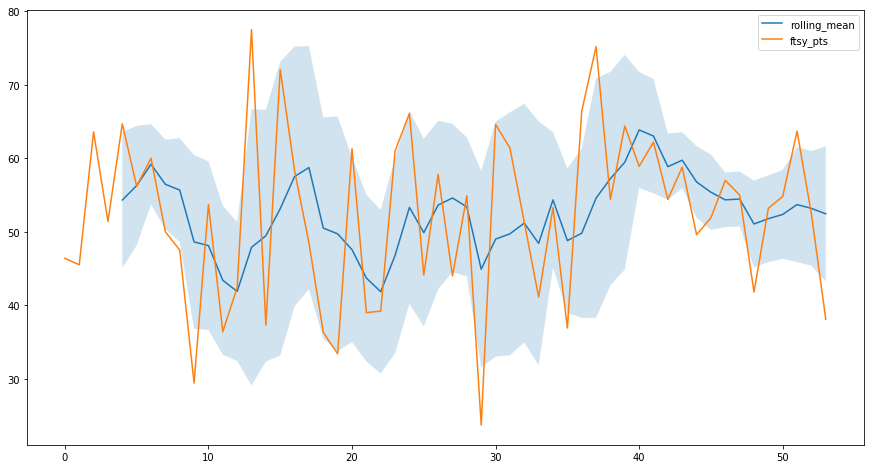

In [814]:
plt.figure(figsize=(15,8))
plt.plot(lebron.rolling_mean)
plt.fill_between(lebron.index, lebron.minus_std, lebron.plus_std, alpha=.2)
plt.plot(lebron.ftsy_pts)
plt.legend()

In [623]:
import plotly.graph_objects as go
import numpy as np

In [634]:
feats = ['gs', 'fg_pct', 'fg3_pct', 'ft_pct', 'trb', 'ast', 'stl', 'blk', 'tov', 'pf', 'pts', 'ftsy_pts', 
 'rolling_mean', 'plus_std', 'minus_std', 'rolling_std']

In [651]:
leb_xtrain = lebron.iloc[:-1][feats].dropna()
leb_ytrain = lebron.iloc[:-1][['ftsy_pts']].iloc[4:]

leb_xtest = lebron.iloc[[-1]][feats].dropna()
leb_ytest = lebron.iloc[[-1]][['ftsy_pts']]

In [657]:
linea = LinearRegression()
linea.fit(leb_xtrain,leb_ytrain)

linea_yh_train = linea.predict(leb_xtrain)
linea_yh_test = linea.predict(leb_xtest)

print('Train Error Unpenalized Linear Model', np.sum((leb_ytrain - linea.predict(leb_xtrain))**2))
print('Test Error Unpenalized Linear Model', np.sum((leb_ytest - linea.predict(leb_xtest))**2))

Train Error Unpenalized Linear Model ftsy_pts    3.227388e-26
dtype: float64
Test Error Unpenalized Linear Model ftsy_pts    2.019484e-28
dtype: float64
